In [1]:
import scanpy as sc
import pandas as pd
import sys
sys.path.append("../")

## Example 1: Single-timepoint modeling

In [2]:
import echidna as ec
ec.pl.activate_plot_settings()

Echidna leverages single-cell and copy number data. In this example, we will use data captured from a patient during the course of anti-PD-1 therapy. The single cell file contains cell-type annotations and a label for the timepoint. Cell-type annotations are not necessary for Echidna to work, though they may be helpful for later analysis. The copy number data is from the WGS of the patient. We have mapped genes to chromosome regions and assigned weighted copy numbers according to the overlap with a given region, thus the continuous nature of the data below. Echidna assumes that copy number is generated from a truncated normal distribution so that we can treat it as a continuous variable.

In [3]:
adata = sc.read_h5ad("data/F01_on_processed.h5")
wdf = pd.read_csv("data/wgs_F01_cellranger.csv", index_col="gene")

In [4]:
# W has two out of order timepoints. I will index for "on" later.
wdf.head()

,on_count,pre_count
gene,,
HES4,0.141322,0.141322
ISG15,1.000000,1.000000
AL645608.1,1.000000,1.000000
AGRN,1.000000,1.000000
AL645608.5,1.000000,1.000000


Pre-process your data if necessary. I've already run this step and saved the processed AnnData. Your pre-processing should filter out low variance genes, save the raw single-cell counts in a layer, and have cluster labels for Echidna to leverage. If you do not have a timepoint label in your `.obs`, you should create one so that Echidna knows which cells to sample from for each timepoint. In the single timepoint case, you can provide a filler label: `adata.obs["timepoint"] = "single_tp"`.

In [5]:
adata = ec.tl.filter_low_var_genes(adata, var_threshold=0.001)

In [6]:
# ec.tl.pre_process(adata, filepath="data/F01_on_processed.h5")

Specify the parameters for your training run, model hyperparameters, and the labels in your AnnData that Echidna should use to construct the data for modeling.

2024-07-24 03:08:30,423 | INFO : Added `.obs['echidna_split']`: the Echidna train/validation split.
 1002 cells in validation set.
2024-07-24 03:08:30,432 | INFO : Added `.var[echidna_matched_genes]` : Labled True for genes contained in W.
2024-07-24 03:08:30,437 | INFO : Added `.var[echidna_W_on_count]` : CN entries for genes contained in W.
training loss: 0.4548 | validation loss: 0.0663:   9%| | 91/1000 [00:14<02:23,  
2024-07-24 03:08:48,360 | INFO : Early stopping has been triggered.


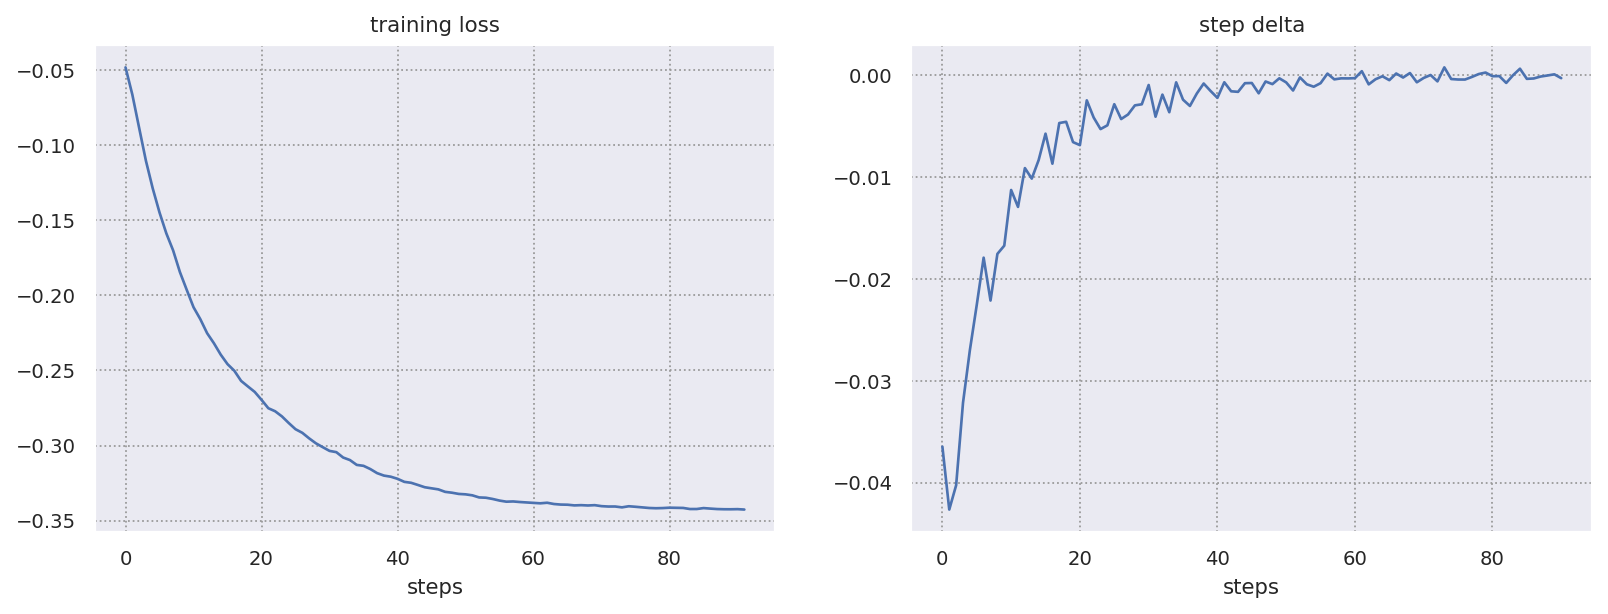

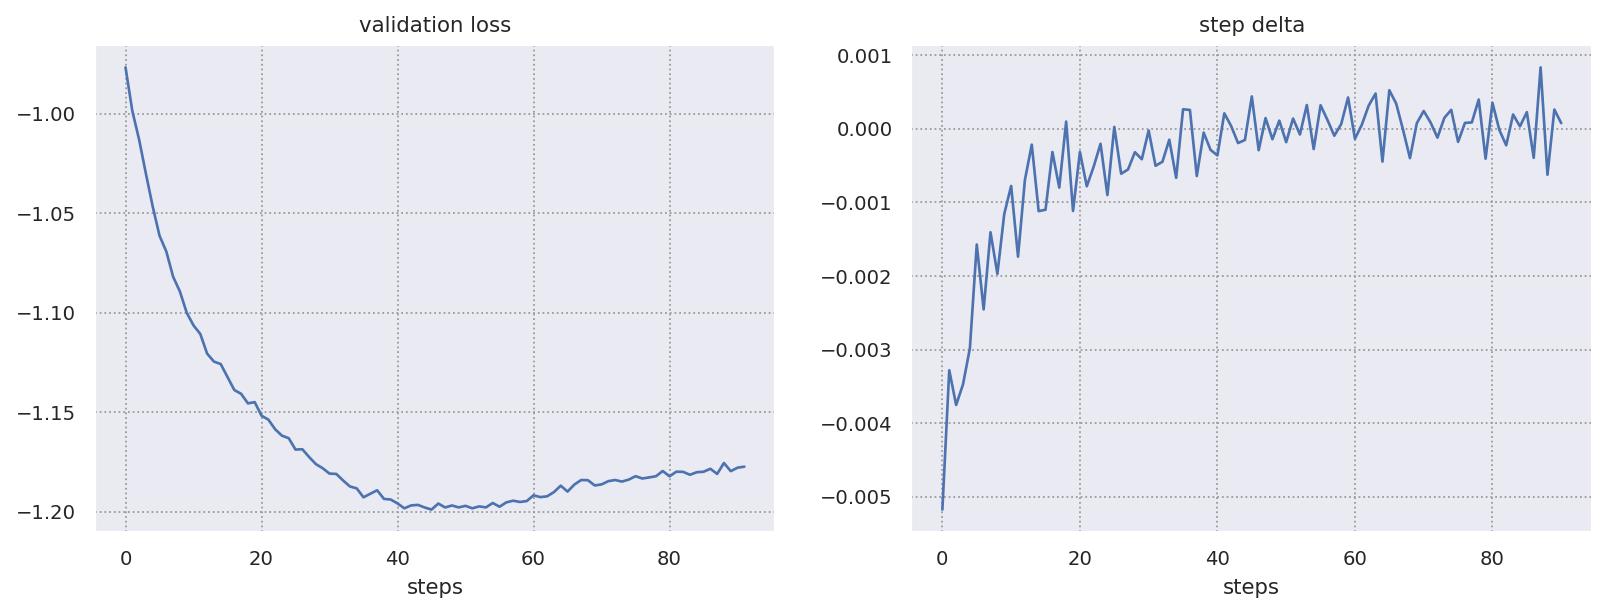

2024-07-24 03:09:11,007 | INFO : Saving echidna model with run_id 20240724-030911.


In [7]:
config = ec.tl.EchidnaConfig(
    timepoint_label = "timepoint", # `assert 'timepoint' in adata.obs.columns`
    counts_layer = "counts", # `assert 'counts' in list(adata.layers.keys())`
    clusters = "pheno_leiden", # `assert 'pheno_leiden' in adata.obs.columns`
    inverse_gamma = True, # Inverse Gamma can be more stable in low data settings
    eta_mean_init = 2., # Our genes average approximately two copies
    patience = 40, # Increase/decrease to affect early stopping
    n_steps = 1000, # Passes through the dataset
)
ec.tl.echidna_train(
     adata # single cell anndata
    , wdf.loc[:,"on_count"] # Copy number pd.DataFrame, indexed with genes. Select for "on" timepoint.
    , config # config settings
)

With `ec.pl.plate_model`, you can visualize the plate model for the single-timepoint.  You may need to install graphviz on your machine and in the environment.

This is a good sanity to check to ensure your data contains the number of timepoints you were expecting. Additionally, you can see the latent variables, observed probabilistic data, deterministic data, and their distributions/dependencies. Any plot in Echidna can be saved if optional parameter `filename` is passed.

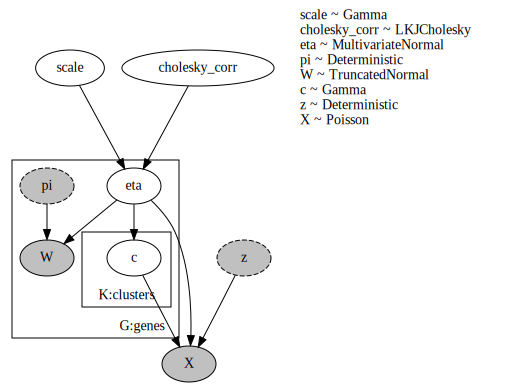

In [8]:
ec.pl.plate_model(adata)

Using our learned model, we do a hierarchical clustering of our posteriror $\eta_k$ to get latent clusters. You may choose to estimate distances between clones at the covariance or correlation level. Echidna defaults to correlation, but covariance can be used with boolean parameter `cov=True`. You may elect between the "elbow", "cophenetic", or "manual" method of thresholding the linkage. Specifying the `threshold` parameter (float) overrides any method as "manual".

In [9]:
ec.tl.echidna_clones(adata, method="elbow")

2024-07-24 03:09:11,655 | INFO : Dendrogram knee point: 10
2024-07-24 03:09:11,655 | INFO : Dendrogram threshold: 1.1514
2024-07-24 03:09:11,659 | INFO : Added `.obs['echidna_clones']`: the learned clones from eta.


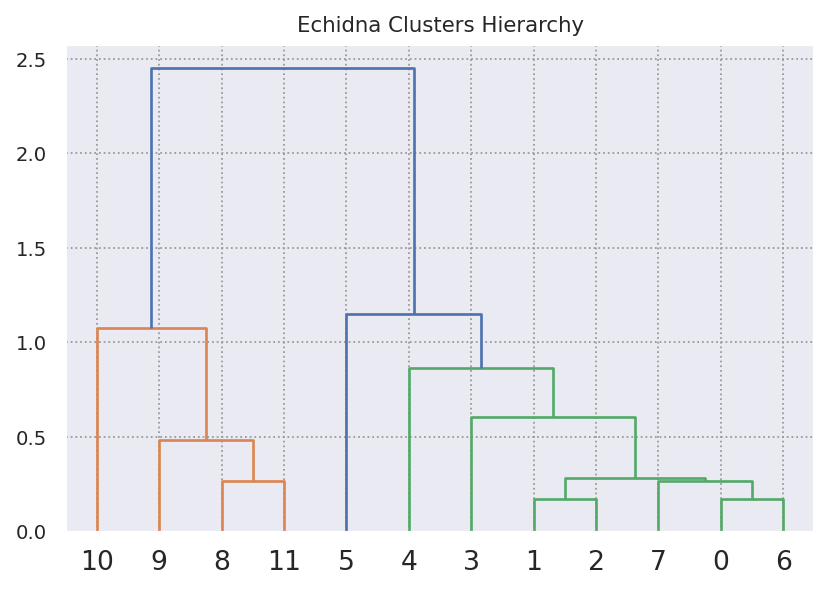

In [10]:
ec.pl.dendrogram(adata)

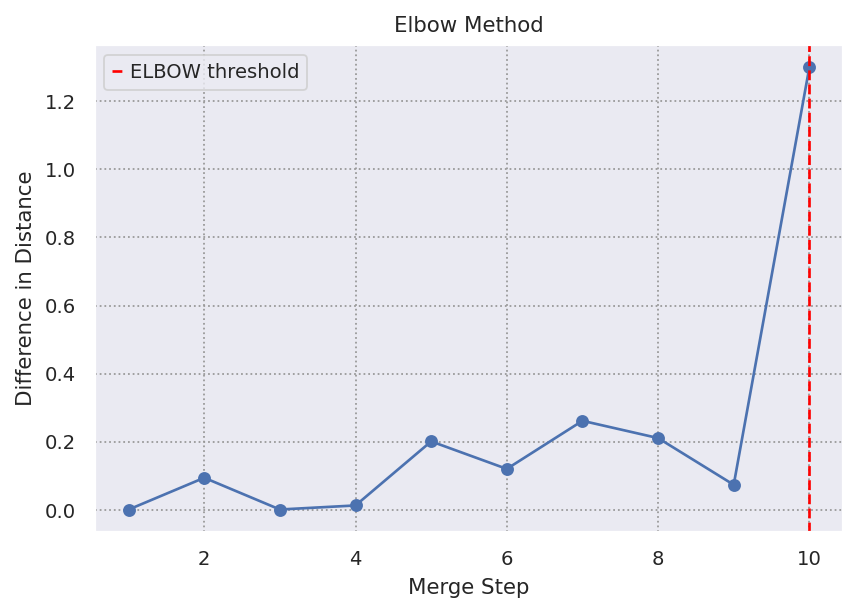

In [11]:
# The elbow plot can only be shown if "elbow" is elected above.
ec.pl.dendrogram(adata, elbow=True)

You may opt to visualize results with U-MAP coordinates, in order to upset many researchers:

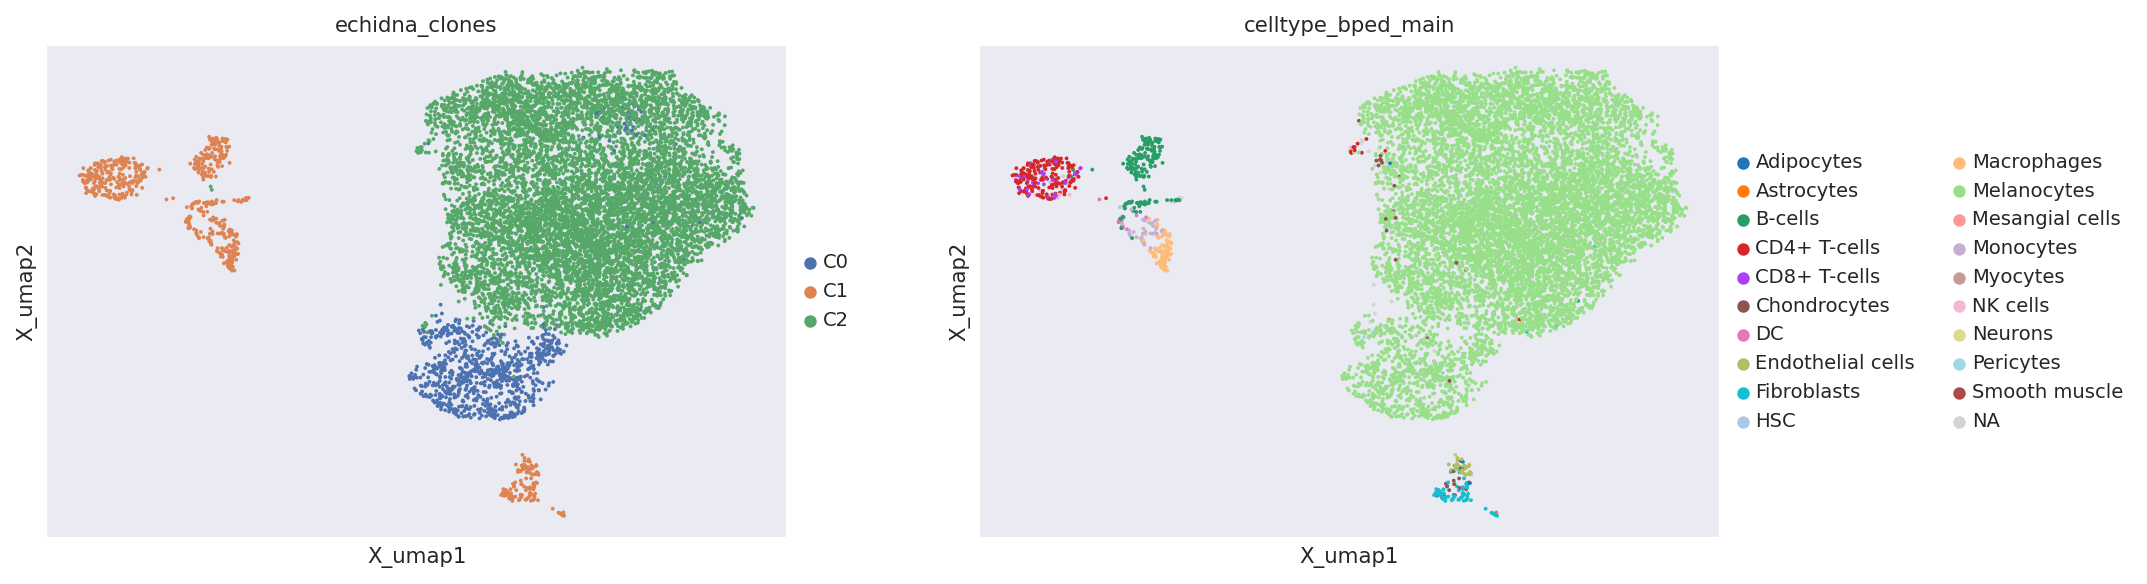

In [12]:
ec.pl.echidna(adata, ["echidna_clones", "celltype_bped_main"])

Echidna provides convenient functions for doing posterior predictive checks (ppc) to ensure your model is able to properly generate data. A sample of "X" for example, should look similar in distribution to the original observed data.

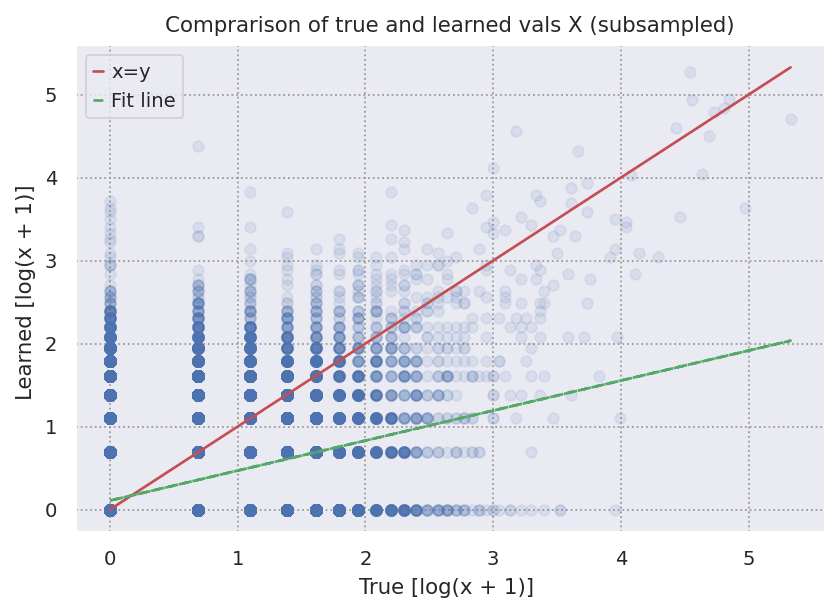

In [13]:
ec.pl.ppc(adata, "X")

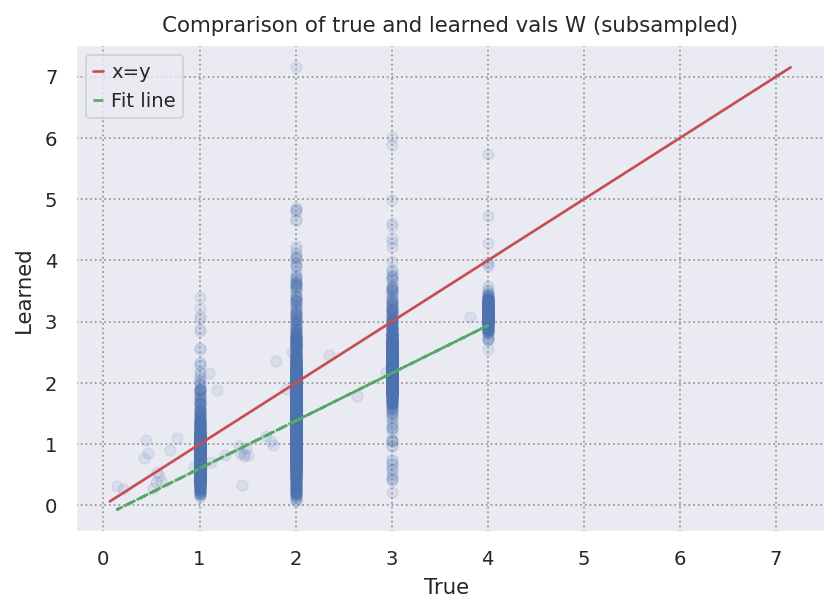

In [14]:
ec.pl.ppc(adata, "W")

To do a posterior predictive check on our latent variables, you need to simulate data from your model by training a model on a sampled X and W. This function will save a simulated version of the model for you, and will use that simulated model to do the posterior predictive check on "eta", the covariance of eta "cov", and on "c".

training loss: 0.4538 | validation loss: 0.0618:   9%| | 93/1000 [00:12<02:04,  
2024-07-24 03:09:52,459 | INFO : Early stopping has been triggered.


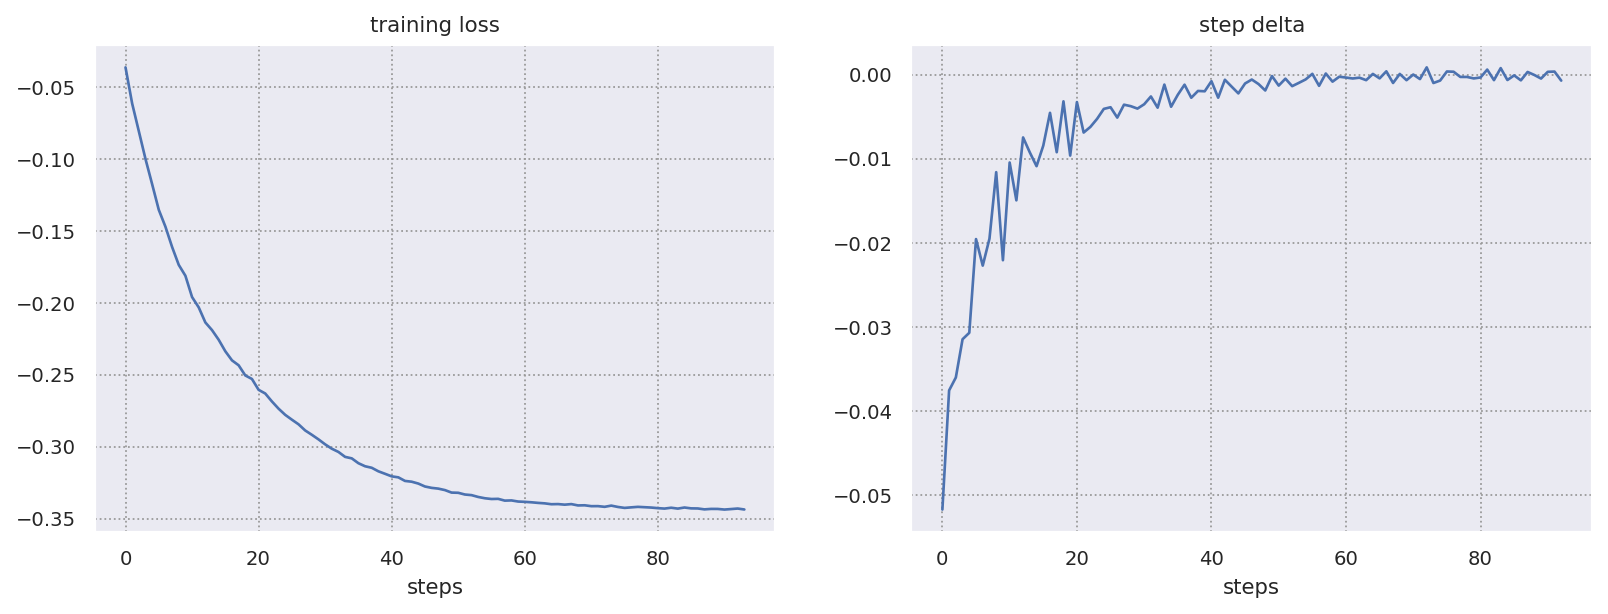

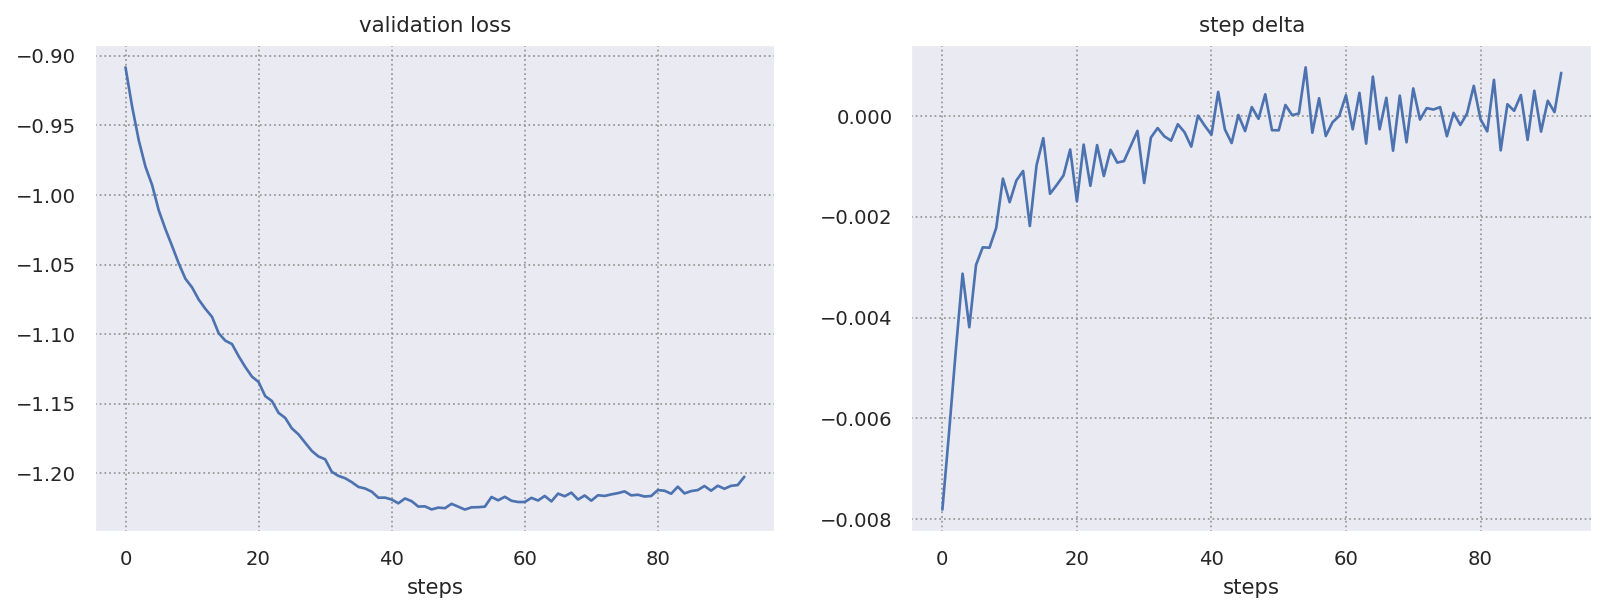

2024-07-24 03:10:13,480 | INFO : Saving echidna simulation model with run_id 20240724-031013.


In [15]:
ec.tl.simulate(adata)

The distance between covariance learned from our original observed data and that of simulated covariance can be visualized with boolean kwarg `difference=True`.

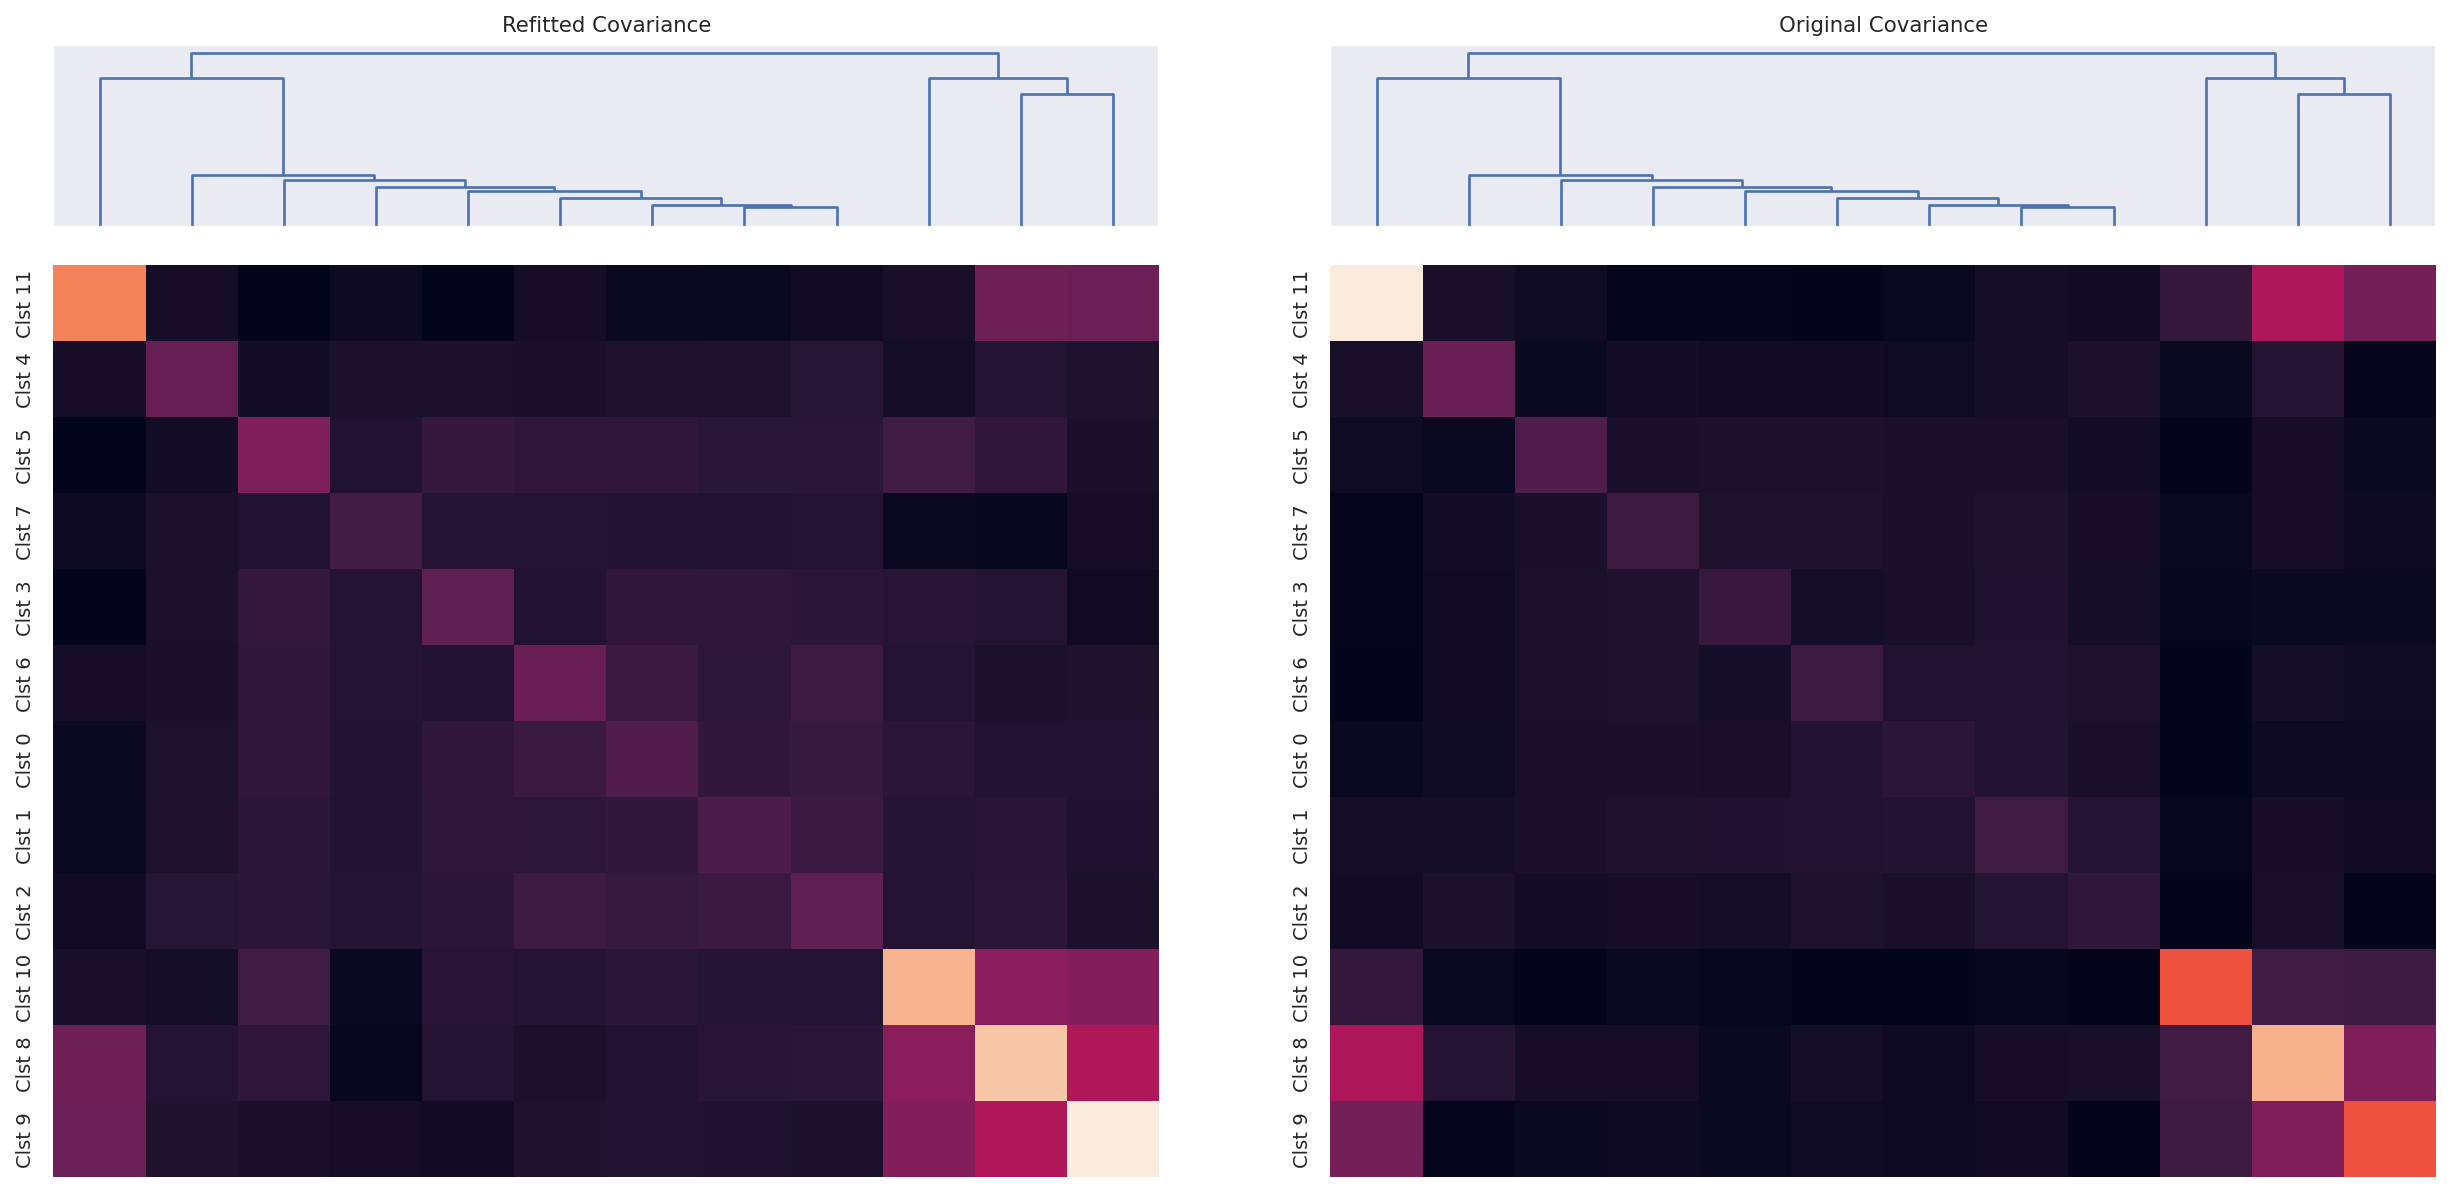

In [16]:
ec.pl.ppc(adata, "cov")

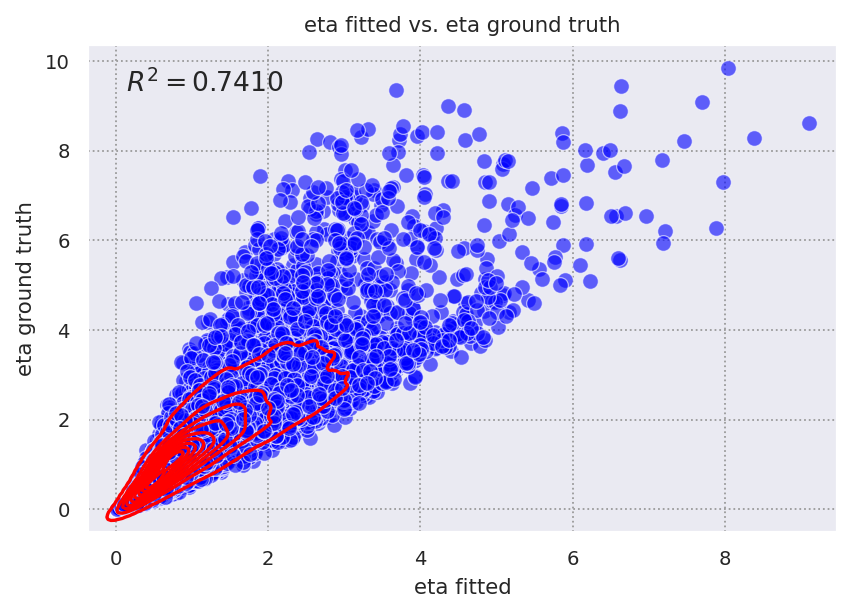

In [17]:
ec.pl.ppc(adata, "eta")

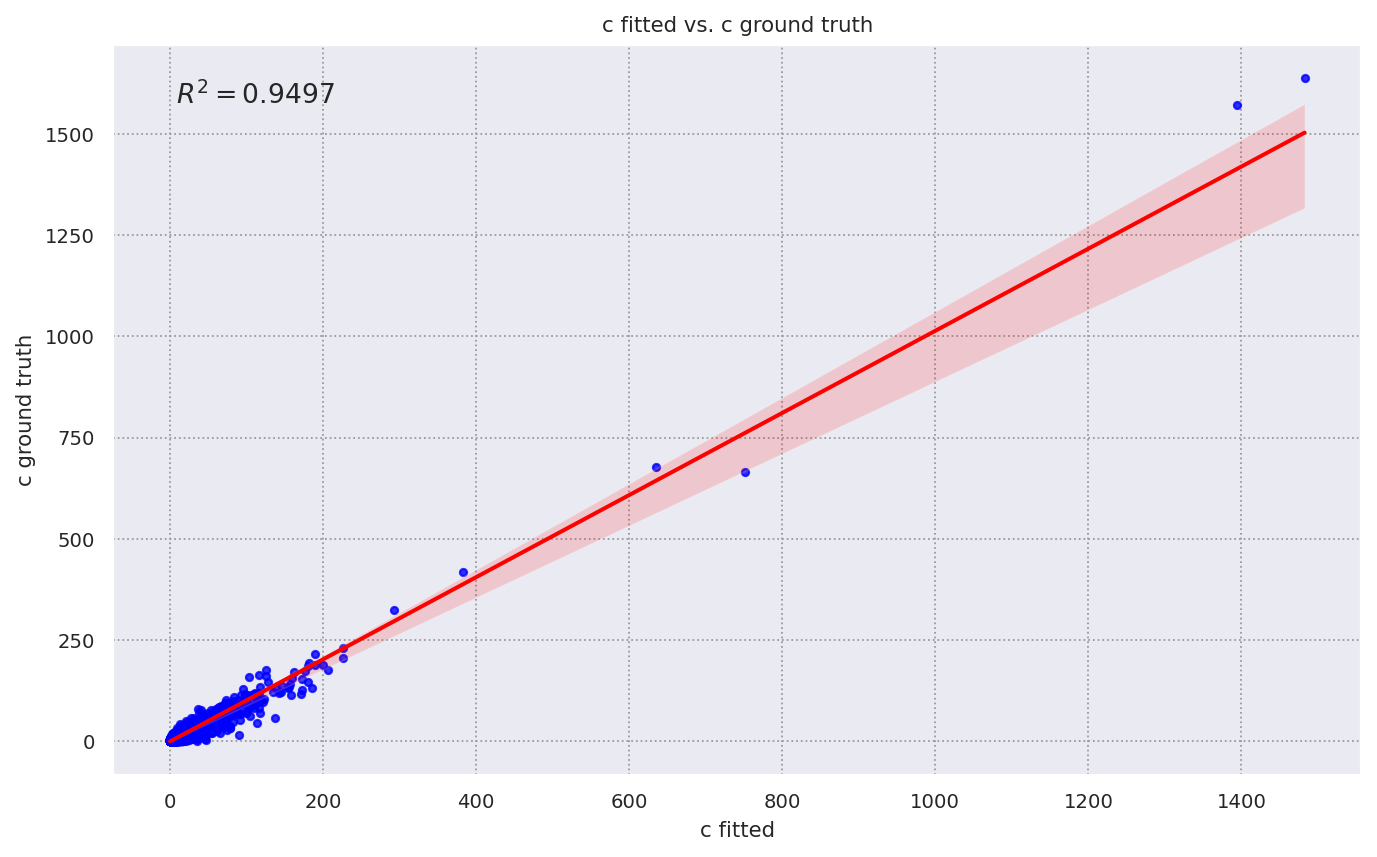

In [18]:
ec.pl.ppc(adata, "c")

Echidna also provides tools for conveniently sampling from the model. The second argument `variable` must be one of or a list of "X", "W", "c", "eta", "cov".

In [19]:
ec.tl.sample(adata, ["X", "W"])

[tensor([[0., 0., 0.,  ..., 0., 3., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 1., 0.],
         [0., 0., 1.,  ..., 0., 2., 0.]], device='cuda:0'),
 tensor([0.3989, 0.6096, 0.5962,  ..., 2.2682, 2.2643, 2.1335], device='cuda:0')]

In [20]:
ec.tl.sample(adata, "eta")

tensor([[ 0.1756,  0.5524, -0.0630,  ...,  0.2778,  2.6038,  0.2983],
        [ 0.6046,  0.2394,  0.8340,  ...,  1.2291,  0.7400,  0.7585],
        [ 0.8336,  0.4158,  0.3911,  ...,  0.0916,  1.8789, -0.0976],
        ...,
        [ 2.1461,  1.8327,  2.0608,  ...,  1.4555,  1.3361,  2.9459],
        [ 2.0059,  1.9117,  1.5077,  ...,  1.8784,  0.9381,  1.7049],
        [ 1.5451,  1.7510,  1.7478,  ...,  1.8760,  1.6659,  0.8279]],
       device='cuda:0')

To save track of the work we've done, write the AnnData object as normally below. The Echidna files will be saved in the present working directory (`!pwd`) of the script/notebook that runs Echidna, so ensure that your file is in that same folder on read. The AnnData contains paths to the saves, as well as a log of the config and other settings used. If you prefer to move your save data, you will find it in `"./_echidna_models/"`. I leave file management to the user.

In [21]:
adata.write_h5ad("data/F01_on_echidna.h5")